We are going to create a model for semantic segmentation for images containing cell neuclei.

In [1]:
# need this in Colab to import tensorflow_examples 
!pip install -q git+https://github.com/tensorflow/examples.git

In [2]:
#Import packages
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,losses,optimizers,callbacks
from tensorflow_examples.models.pix2pix import pix2pix
from IPython.display import clear_output
import matplotlib.pyplot as plt
import cv2
import numpy as np
from scipy import io
import glob, os

In [3]:
# Get the access from google drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [4]:
root_path = "/content/gdrive/MyDrive/data-science-bowl-2018/data-science-bowl-2018-2/"
train_path = os.path.join(root_path, "train")
test_path = os.path.join(root_path, "test")
train_images = []
train_masks = []
test_images = []
test_masks = []

In [5]:
# Next we are going to recolor the images and map them into the same size, then append them into the corresponding list. 
# We use sorted to arrange the inputs and masks in the same order. 

train_image_dir = os.path.join(train_path,'inputs')
for image_file in sorted(os.listdir(train_image_dir)):
    train_img = cv2.imread(os.path.join(train_image_dir,image_file))
    train_img = cv2.cvtColor(train_img, cv2.COLOR_BGR2RGB)
    train_img = cv2.resize(train_img,(128,128))
    train_images.append(train_img)

In [6]:
test_image_dir = os.path.join(test_path,'inputs')
for image_file in sorted(os.listdir(test_image_dir)):
    test_img = cv2.imread(os.path.join(test_image_dir,image_file))
    test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
    test_img = cv2.resize(test_img,(128,128))
    test_images.append(test_img)

In [7]:
train_mask_dir = os.path.join(train_path,'masks')
for mask_file in sorted(os.listdir(train_mask_dir)):
    train_mask = cv2.imread(os.path.join(train_mask_dir,mask_file),cv2.IMREAD_GRAYSCALE)
    train_mask = cv2.resize(train_mask,(128,128))
    train_masks.append(train_mask)

In [8]:
test_mask_dir = os.path.join(test_path,'masks')
for mask_file in sorted(os.listdir(test_mask_dir)):
    test_mask = cv2.imread(os.path.join(test_mask_dir,mask_file),cv2.IMREAD_GRAYSCALE)
    test_mask = cv2.resize(test_mask,(128,128))
    test_masks.append(test_mask)

In [9]:
#1.4. Convert the lists into numpy array
train_images_np = np.array(train_images)
train_masks_np = np.array(train_masks)
test_images_np = np.array(test_images)
test_masks_np = np.array(test_masks)

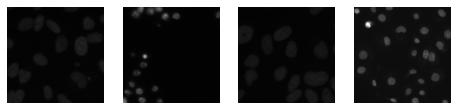

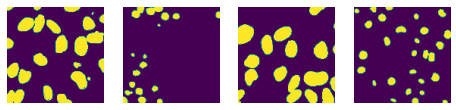

In [10]:
plt.figure(figsize=(10,10))
for i in range(1,5):
    plt.subplot(1,5,i)
    plt.imshow(test_images_np[i])
    plt.axis('off')
    
plt.show()

plt.figure(figsize=(10,10))
for i in range(1,5):
    plt.subplot(1,5,i)
    plt.imshow(test_masks_np[i])
    plt.axis('off')
    
plt.show()

In [11]:
#2. Data preprocessing
#2.1. Expand the mask dimension
train_masks_np_exp = np.expand_dims(train_masks_np,axis=-1)
test_masks_np_exp = np.expand_dims(test_masks_np,axis=-1)
#Check the expanded mask output
print(np.unique(train_masks_np_exp[0]))


[  0  64 128 191 255]


In [12]:
#2.2. Convert the mask values into class labels
converted_train_masks = np.round(train_masks_np_exp/255).astype(np.int64)
converted_test_masks = np.round(test_masks_np_exp/255).astype(np.int64)
#Check the converted mask output
print(np.unique(converted_train_masks[0]))


[0 1]


In [13]:
#2.3. Normalize image pixels value
converted_train_images = train_images_np / 255.0
converted_test_images = test_images_np / 255.0
# Check the converted train image
print(converted_train_images[0])


[[[0.01960784 0.01960784 0.01960784]
  [0.01960784 0.01960784 0.01960784]
  [0.01960784 0.01960784 0.01960784]
  ...
  [0.01960784 0.01960784 0.01960784]
  [0.01960784 0.01960784 0.01960784]
  [0.01568627 0.01568627 0.01568627]]

 [[0.01960784 0.01960784 0.01960784]
  [0.01960784 0.01960784 0.01960784]
  [0.01568627 0.01568627 0.01568627]
  ...
  [0.01568627 0.01568627 0.01568627]
  [0.01568627 0.01568627 0.01568627]
  [0.01568627 0.01568627 0.01568627]]

 [[0.02352941 0.02352941 0.02352941]
  [0.01960784 0.01960784 0.01960784]
  [0.01568627 0.01568627 0.01568627]
  ...
  [0.01568627 0.01568627 0.01568627]
  [0.01568627 0.01568627 0.01568627]
  [0.01568627 0.01568627 0.01568627]]

 ...

 [[0.01960784 0.01960784 0.01960784]
  [0.01568627 0.01568627 0.01568627]
  [0.01568627 0.01568627 0.01568627]
  ...
  [0.01960784 0.01960784 0.01960784]
  [0.02745098 0.02745098 0.02745098]
  [0.02745098 0.02745098 0.02745098]]

 [[0.01960784 0.01960784 0.01960784]
  [0.01960784 0.01960784 0.01960784]


In [14]:
#2.4. Convert the numpy arrays into tensor 
x_train_tensor = tf.data.Dataset.from_tensor_slices(converted_train_images)
x_test_tensor = tf.data.Dataset.from_tensor_slices(converted_test_images )
y_train_tensor = tf.data.Dataset.from_tensor_slices(converted_train_masks)
y_test_tensor = tf.data.Dataset.from_tensor_slices(converted_test_masks)

#2.6. Combine the images and masks using zip
train_dataset = tf.data.Dataset.zip((x_train_tensor,y_train_tensor))
test_dataset = tf.data.Dataset.zip((x_test_tensor,y_test_tensor))


In [15]:
#[EXTRA] Create a subclass layer for data augmentation
class Augment(layers.Layer):
    def __init__(self,seed=42):
        super().__init__()
        self.augment_inputs = layers.RandomFlip(mode='horizontal',seed=seed)
        self.augment_labels = layers.RandomFlip(mode='horizontal',seed=seed)
        
    def call(self,inputs,labels):
        inputs = self.augment_inputs(inputs)
        labels = self.augment_labels(labels)
        return inputs,labels


In [16]:
#2.7. Convert into prefetch dataset
BATCH_SIZE = 16
AUTOTUNE = tf.data.AUTOTUNE
BUFFER_SIZE = 500
TRAIN_SIZE = len(train_dataset)
STEPS_PER_EPOCH = TRAIN_SIZE//BATCH_SIZE

train_batches = (
    train_dataset
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE)
    )

test_batches = (test_dataset
    .cache()
    .batch(BATCH_SIZE)
    .repeat()
    .map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE))


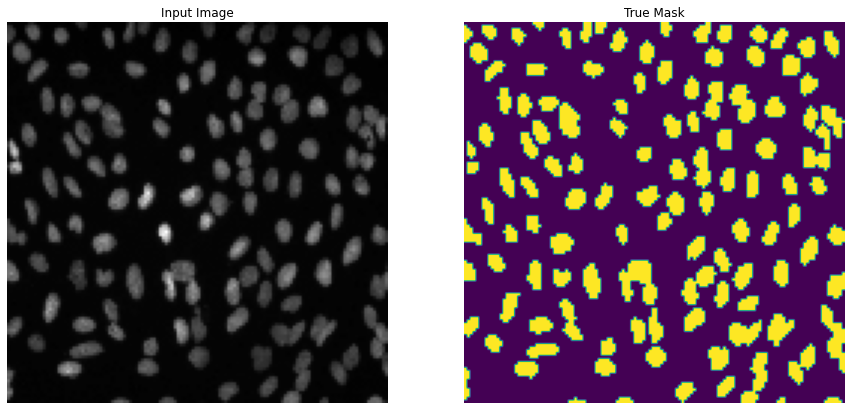

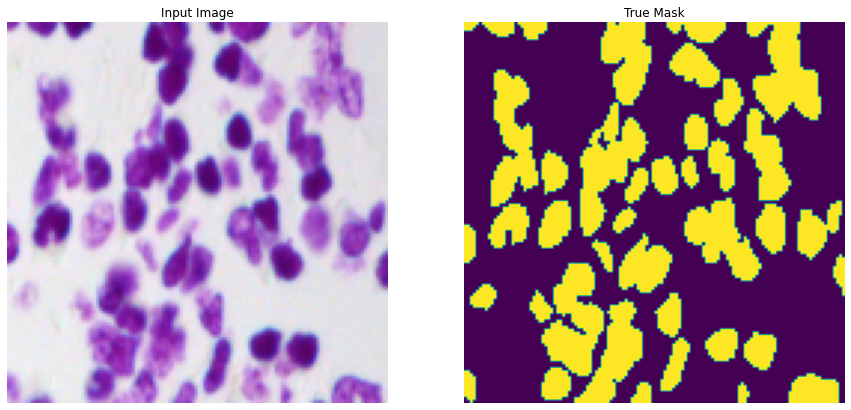

In [17]:
#extra: Visualize some examples
def display(display_list):
    plt.figure(figsize=(15,15))
    title = ['Input Image','True Mask','Predicted Mask']
    
    for i in range(len(display_list)):
        plt.subplot(1,len(display_list),i+1)
        plt.title(title[i])
        plt.imshow(keras.utils.array_to_img(display_list[i]))
        plt.axis('off')
        
    plt.show()
    
for images, masks in train_batches.take(2):
    sample_image,sample_mask = images[0],masks[0]
    display([sample_image,sample_mask])


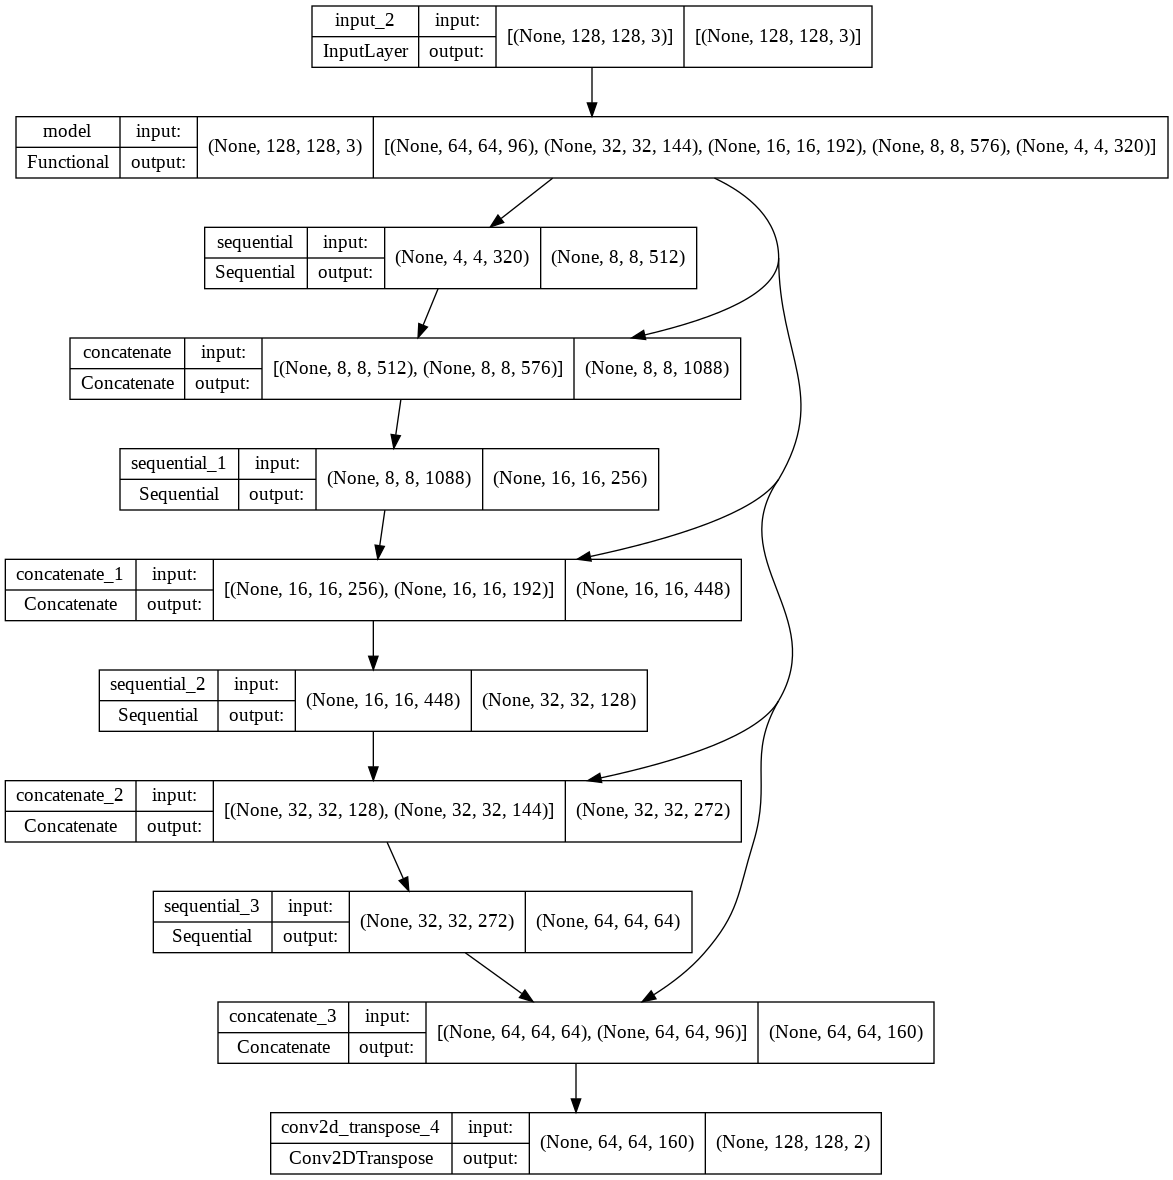

In [18]:
#3. Create image segmentation model
#3.1. Use a pretrained model as the feature extraction layers
base_model = keras.applications.MobileNetV2(input_shape=[128,128,3],include_top=False)

#3.2. List down some activation layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
    ]

base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

#Define the feature extraction model
down_stack = keras.Model(inputs=base_model.input, outputs=base_model_outputs)
down_stack.trainable = False

#Define the upsampling path
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

def unet_model(output_channels:int):
    inputs = layers.Input(shape=[128,128,3])
    #Apply functional API to construct U-Net
    #Downsampling through the model
    skips = down_stack(inputs)
    x = skips[-1]
    skips = reversed(skips[:-1])
    
    #Upsampling and establishing the skip connections(concatenation)
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = layers.Concatenate()
        x = concat([x,skip])
        
    #This is the last layer of the model (output layer)
    last = layers.Conv2DTranspose(
        filters=output_channels,kernel_size=3,strides=2,padding='same') #64x64 --> 128x128
    
    x = last(x)
    
    return keras.Model(inputs=inputs, outputs=x)

#Make of use of the function to construct the entire U-Net
OUTPUT_CLASSES = 2

model = unet_model(output_channels=OUTPUT_CLASSES)
#Compile the model
loss = losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(keras.optimizers.Adam(learning_rate=0.0001),loss=loss,metrics=['accuracy'])
keras.utils.plot_model(model, show_shapes=True)


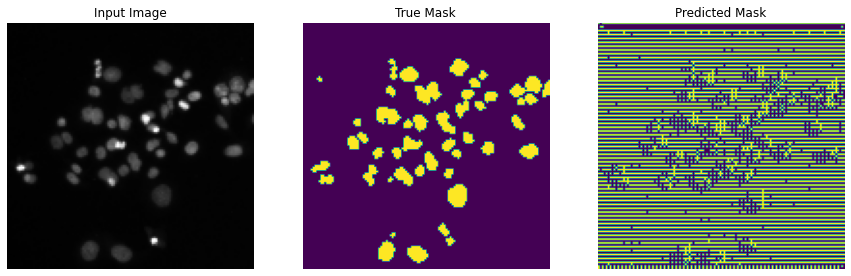

In [19]:
#Create functions to show predictions
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask,axis=-1)
    pred_mask = pred_mask[...,tf.newaxis]
    return pred_mask[0]

def show_predictions(dataset,num=1):
    if dataset:
        for image,mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0],mask[0],create_mask(pred_mask)])
            
    else:
        display([sample_image,sample_mask,create_mask(model.predict(sample_image[tf.newaxis,...]))])
        
#Test out the show_prediction function
show_predictions(dataset=train_batches)

#Create a callback to help display results during model training
class DisplayCallback(callbacks.Callback):
    def on_epoch_end(self,epoch,logs=None):
        show_predictions(dataset=train_batches)
        print('\nSample Prediction after epoch {}\n'.format(epoch+1))
        

Epoch 1/15
37/37 [==============================] - ETA: 0s - loss: 0.5672 - accuracy: 0.7546

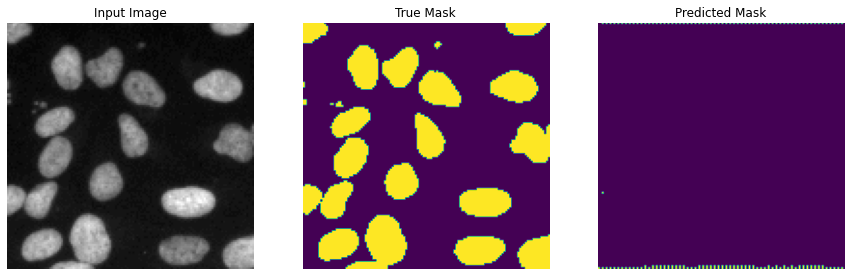


Sample Prediction after epoch 1

37/37 [==============================] - 52s 1s/step - loss: 0.5672 - accuracy: 0.7546
Epoch 2/15
37/37 [==============================] - ETA: 0s - loss: 0.3078 - accuracy: 0.8755

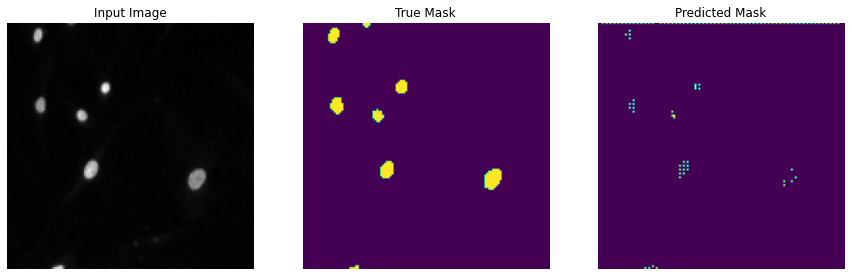


Sample Prediction after epoch 2

37/37 [==============================] - 51s 1s/step - loss: 0.3078 - accuracy: 0.8755
Epoch 3/15
37/37 [==============================] - ETA: 0s - loss: 0.2321 - accuracy: 0.9068

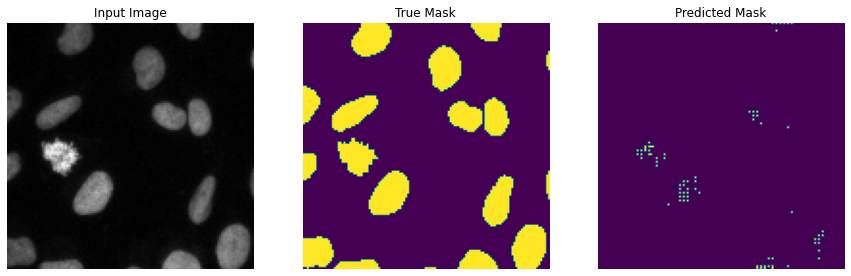


Sample Prediction after epoch 3

37/37 [==============================] - 51s 1s/step - loss: 0.2321 - accuracy: 0.9068
Epoch 4/15
37/37 [==============================] - ETA: 0s - loss: 0.1977 - accuracy: 0.9227

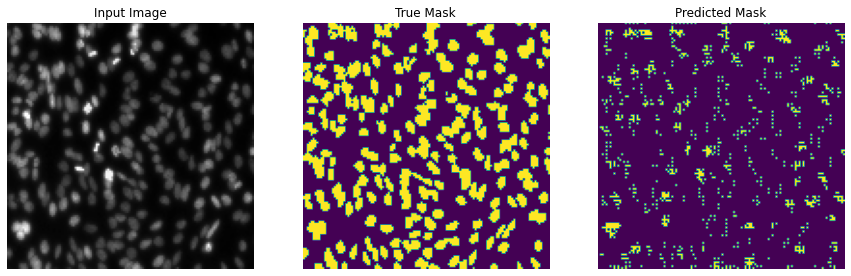


Sample Prediction after epoch 4

37/37 [==============================] - 49s 1s/step - loss: 0.1977 - accuracy: 0.9227
Epoch 5/15
37/37 [==============================] - ETA: 0s - loss: 0.1699 - accuracy: 0.9353

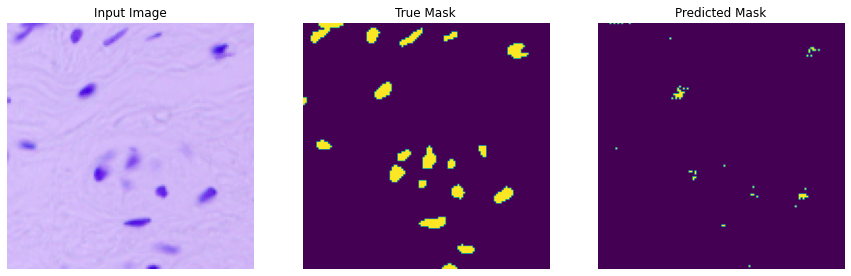


Sample Prediction after epoch 5

37/37 [==============================] - 47s 1s/step - loss: 0.1699 - accuracy: 0.9353
Epoch 6/15
37/37 [==============================] - ETA: 0s - loss: 0.1576 - accuracy: 0.9392

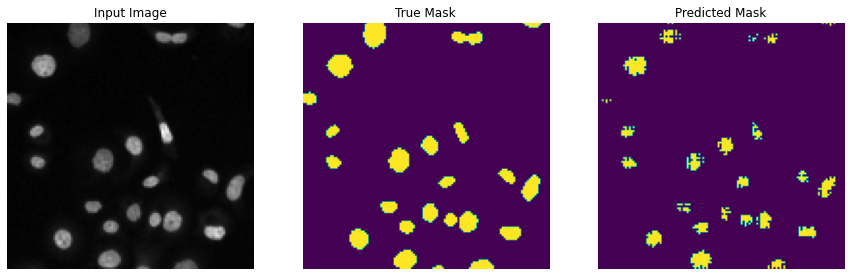


Sample Prediction after epoch 6

37/37 [==============================] - 47s 1s/step - loss: 0.1576 - accuracy: 0.9392
Epoch 7/15
37/37 [==============================] - ETA: 0s - loss: 0.1393 - accuracy: 0.9469

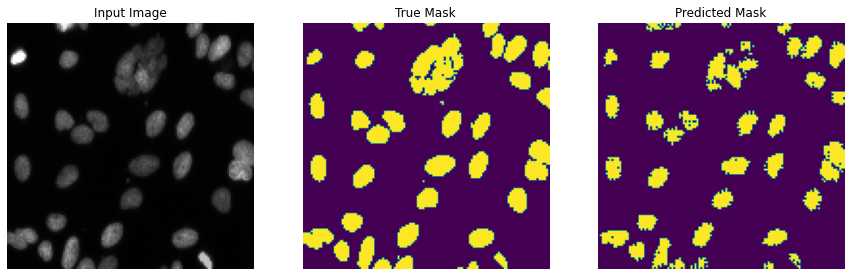


Sample Prediction after epoch 7

37/37 [==============================] - 46s 1s/step - loss: 0.1393 - accuracy: 0.9469
Epoch 8/15
37/37 [==============================] - ETA: 0s - loss: 0.1341 - accuracy: 0.9481

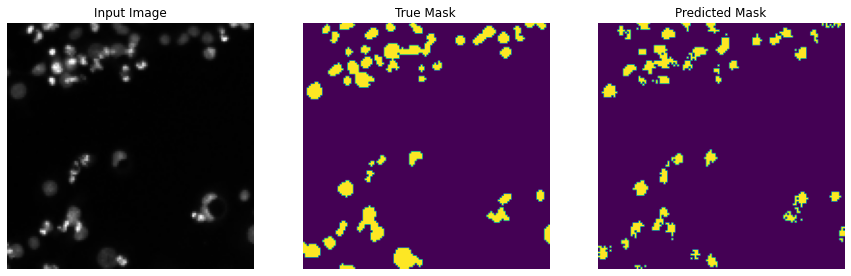


Sample Prediction after epoch 8

37/37 [==============================] - 47s 1s/step - loss: 0.1341 - accuracy: 0.9481
Epoch 9/15
37/37 [==============================] - ETA: 0s - loss: 0.1277 - accuracy: 0.9503

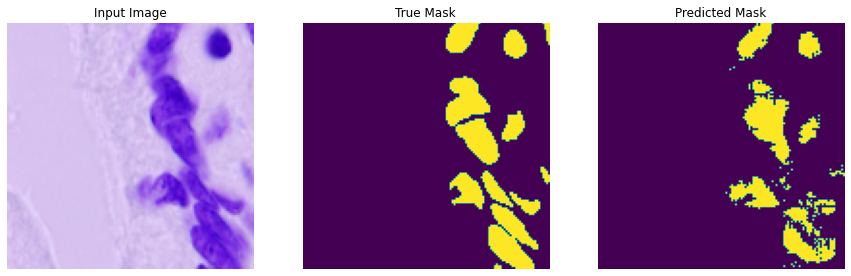


Sample Prediction after epoch 9

37/37 [==============================] - 47s 1s/step - loss: 0.1277 - accuracy: 0.9503
Epoch 10/15
37/37 [==============================] - ETA: 0s - loss: 0.1193 - accuracy: 0.9537

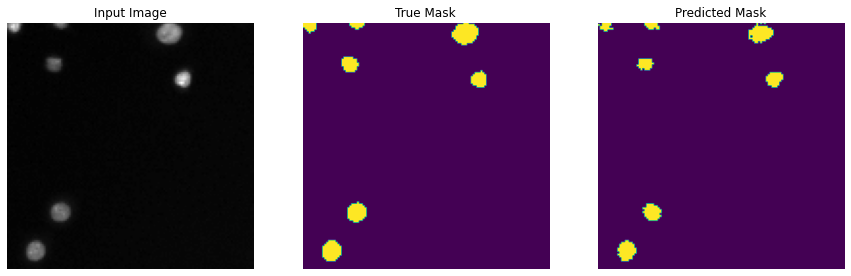


Sample Prediction after epoch 10

37/37 [==============================] - 47s 1s/step - loss: 0.1193 - accuracy: 0.9537
Epoch 11/15
37/37 [==============================] - ETA: 0s - loss: 0.1194 - accuracy: 0.9527

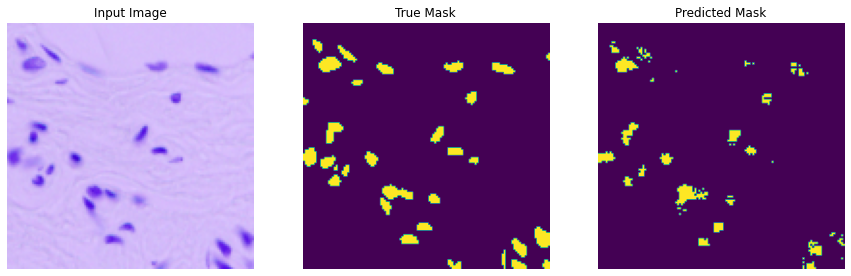


Sample Prediction after epoch 11

37/37 [==============================] - 48s 1s/step - loss: 0.1194 - accuracy: 0.9527
Epoch 12/15
37/37 [==============================] - ETA: 0s - loss: 0.1118 - accuracy: 0.9560

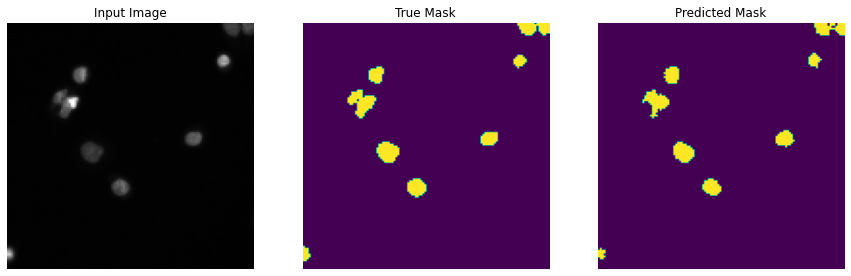


Sample Prediction after epoch 12

37/37 [==============================] - 46s 1s/step - loss: 0.1118 - accuracy: 0.9560
Epoch 13/15
37/37 [==============================] - ETA: 0s - loss: 0.1089 - accuracy: 0.9572

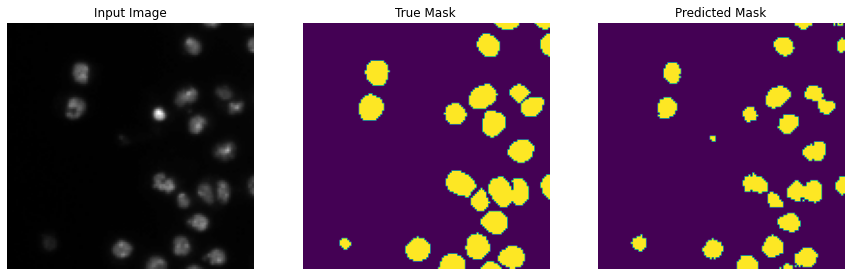


Sample Prediction after epoch 13

37/37 [==============================] - 48s 1s/step - loss: 0.1089 - accuracy: 0.9572
Epoch 14/15
37/37 [==============================] - ETA: 0s - loss: 0.1080 - accuracy: 0.9570

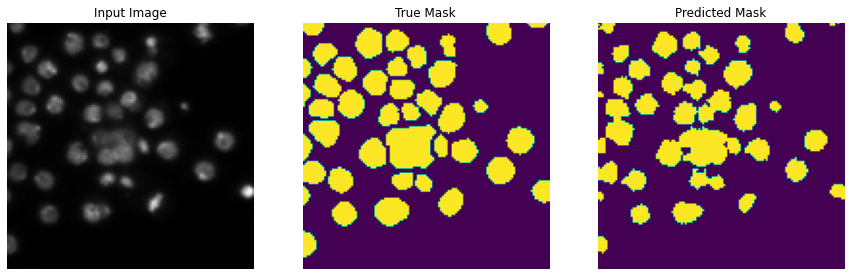


Sample Prediction after epoch 14

37/37 [==============================] - 48s 1s/step - loss: 0.1080 - accuracy: 0.9570
Epoch 15/15
37/37 [==============================] - ETA: 0s - loss: 0.1062 - accuracy: 0.9577

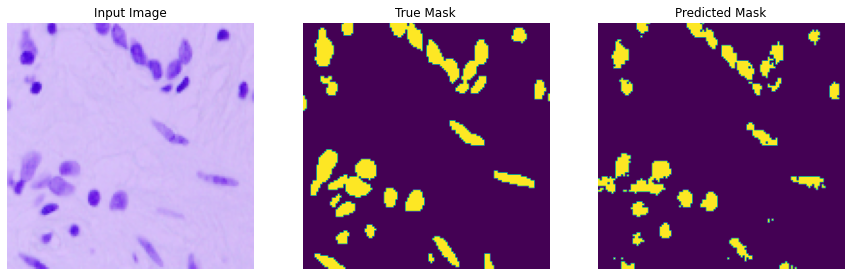


Sample Prediction after epoch 15

37/37 [==============================] - 47s 1s/step - loss: 0.1062 - accuracy: 0.9577


In [20]:
#4. Model training
#Hyperparameters for the model
EPOCHS = 15
VAL_SUBSPLITS = 5
VALIDATION_STEPS = len(test_dataset)//BATCH_SIZE//VAL_SUBSPLITS

history = model.fit(train_batches,validation_data=test_batches,epochs=EPOCHS,steps_per_epoch=STEPS_PER_EPOCH,validation_steps=VALIDATION_STEPS,callbacks=[DisplayCallback()])


Epoch 1/15
37/37 [==============================] - ETA: 0s - loss: 0.1041 - accuracy: 0.9585

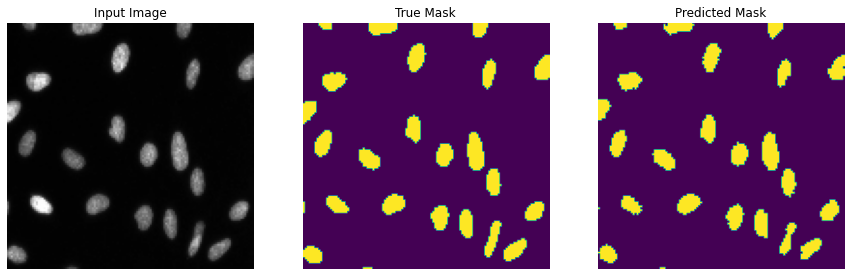


Sample Prediction after epoch 1

37/37 [==============================] - 48s 1s/step - loss: 0.1041 - accuracy: 0.9585
Epoch 2/15
37/37 [==============================] - ETA: 0s - loss: 0.1008 - accuracy: 0.9597

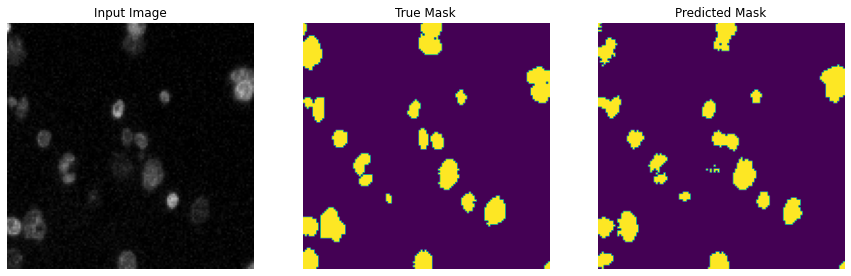


Sample Prediction after epoch 2

37/37 [==============================] - 47s 1s/step - loss: 0.1008 - accuracy: 0.9597
Epoch 3/15
37/37 [==============================] - ETA: 0s - loss: 0.0991 - accuracy: 0.9603

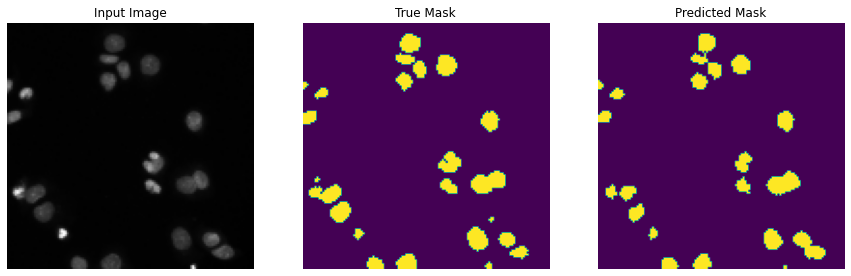


Sample Prediction after epoch 3

37/37 [==============================] - 47s 1s/step - loss: 0.0991 - accuracy: 0.9603
Epoch 4/15
37/37 [==============================] - ETA: 0s - loss: 0.0989 - accuracy: 0.9603

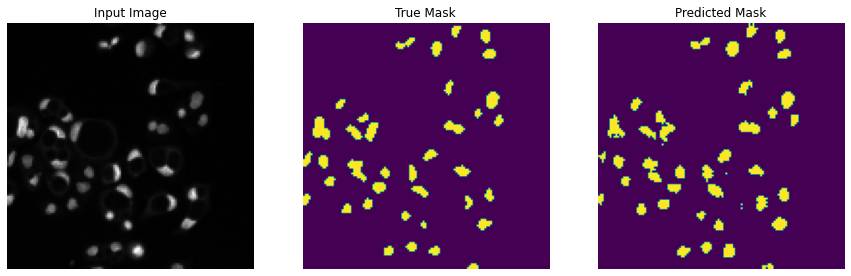


Sample Prediction after epoch 4

37/37 [==============================] - 48s 1s/step - loss: 0.0989 - accuracy: 0.9603
Epoch 5/15
37/37 [==============================] - ETA: 0s - loss: 0.0960 - accuracy: 0.9618

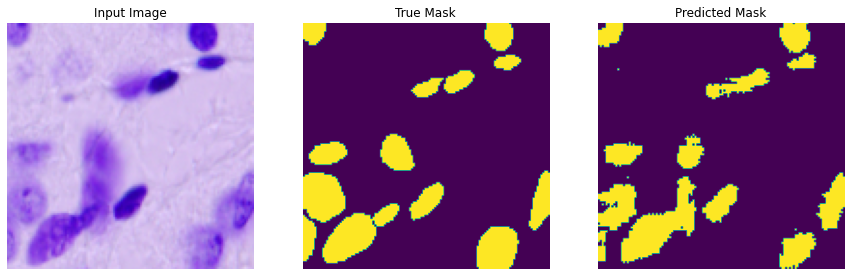


Sample Prediction after epoch 5

37/37 [==============================] - 46s 1s/step - loss: 0.0960 - accuracy: 0.9618
Epoch 6/15
37/37 [==============================] - ETA: 0s - loss: 0.0952 - accuracy: 0.9614

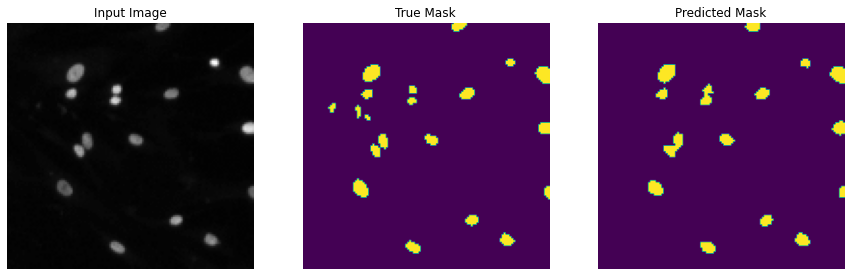


Sample Prediction after epoch 6

37/37 [==============================] - 47s 1s/step - loss: 0.0952 - accuracy: 0.9614
Epoch 7/15
37/37 [==============================] - ETA: 0s - loss: 0.0932 - accuracy: 0.9625

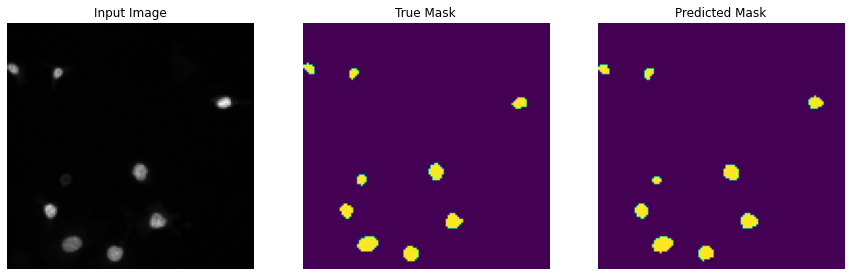


Sample Prediction after epoch 7

37/37 [==============================] - 46s 1s/step - loss: 0.0932 - accuracy: 0.9625
Epoch 8/15
37/37 [==============================] - ETA: 0s - loss: 0.0932 - accuracy: 0.9623

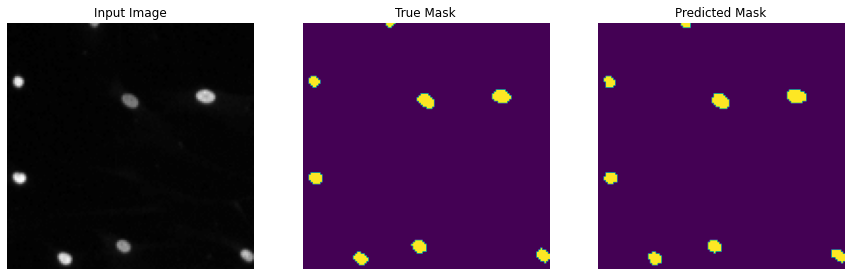


Sample Prediction after epoch 8

37/37 [==============================] - 46s 1s/step - loss: 0.0932 - accuracy: 0.9623
Epoch 9/15
37/37 [==============================] - ETA: 0s - loss: 0.0917 - accuracy: 0.9630

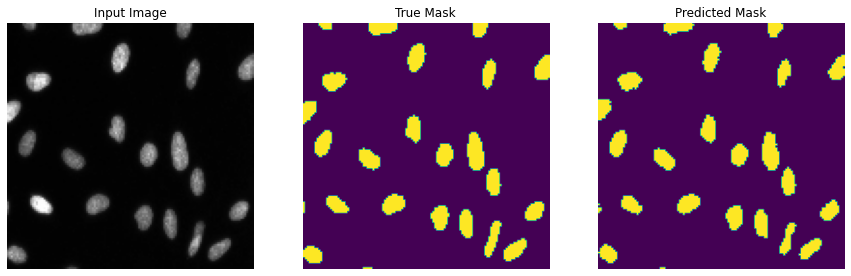


Sample Prediction after epoch 9

37/37 [==============================] - 47s 1s/step - loss: 0.0917 - accuracy: 0.9630
Epoch 10/15
37/37 [==============================] - ETA: 0s - loss: 0.0864 - accuracy: 0.9652

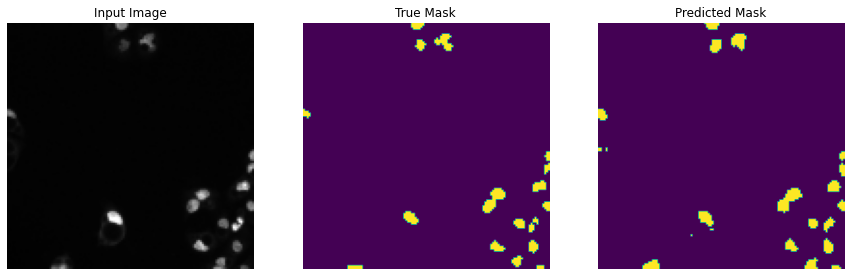


Sample Prediction after epoch 10

37/37 [==============================] - 47s 1s/step - loss: 0.0864 - accuracy: 0.9652
Epoch 11/15
37/37 [==============================] - ETA: 0s - loss: 0.0896 - accuracy: 0.9639

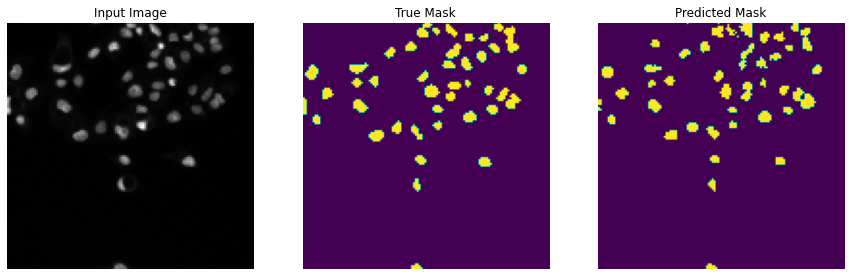


Sample Prediction after epoch 11

37/37 [==============================] - 47s 1s/step - loss: 0.0896 - accuracy: 0.9639
Epoch 12/15
37/37 [==============================] - ETA: 0s - loss: 0.0839 - accuracy: 0.9664

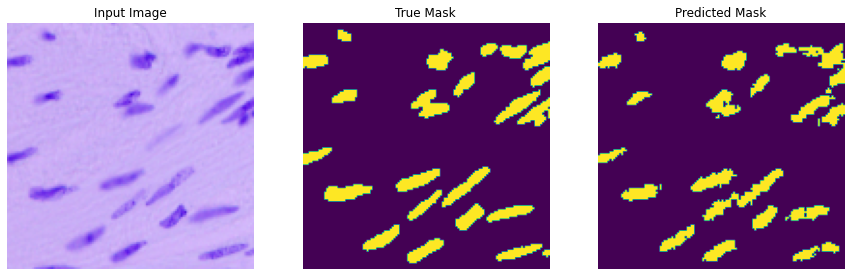


Sample Prediction after epoch 12

37/37 [==============================] - 47s 1s/step - loss: 0.0839 - accuracy: 0.9664
Epoch 13/15
37/37 [==============================] - ETA: 0s - loss: 0.0836 - accuracy: 0.9667

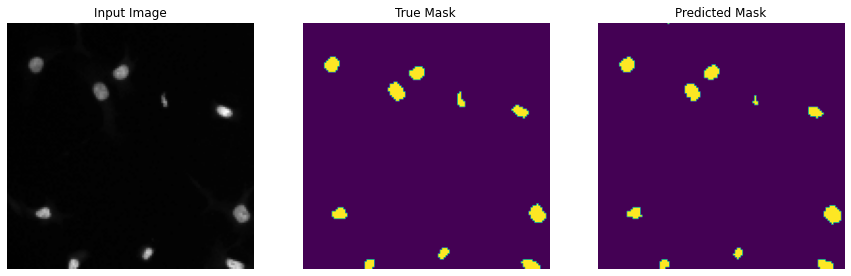


Sample Prediction after epoch 13

37/37 [==============================] - 48s 1s/step - loss: 0.0836 - accuracy: 0.9667
Epoch 14/15
37/37 [==============================] - ETA: 0s - loss: 0.0905 - accuracy: 0.9631

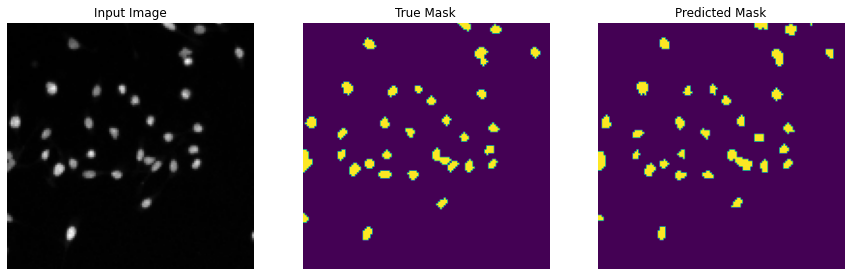


Sample Prediction after epoch 14

37/37 [==============================] - 49s 1s/step - loss: 0.0905 - accuracy: 0.9631
Epoch 15/15
37/37 [==============================] - ETA: 0s - loss: 0.0879 - accuracy: 0.9647

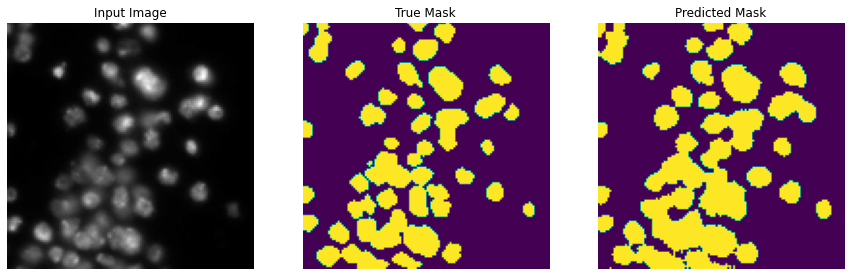


Sample Prediction after epoch 15

37/37 [==============================] - 49s 1s/step - loss: 0.0879 - accuracy: 0.9647


In [21]:
#Further training
history = model.fit(train_batches,validation_data=test_batches,epochs=EPOCHS,steps_per_epoch=STEPS_PER_EPOCH,validation_steps=VALIDATION_STEPS,callbacks=[DisplayCallback()])

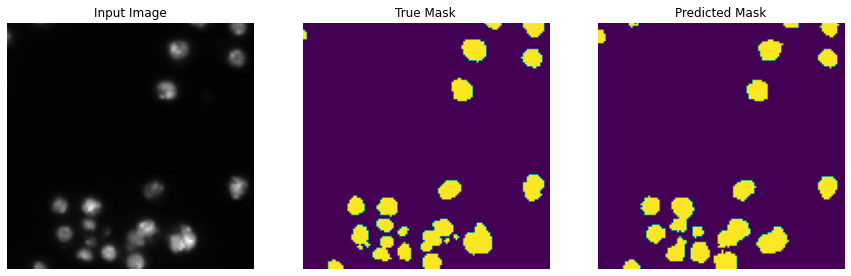

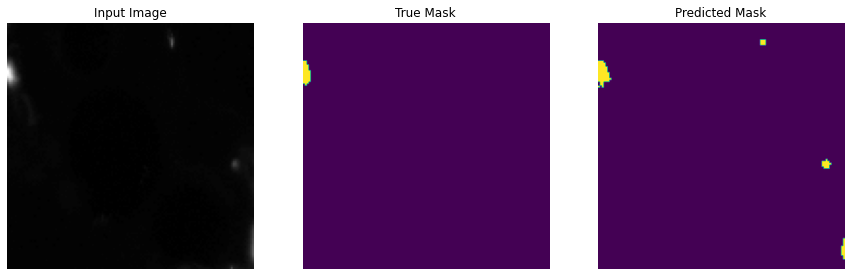

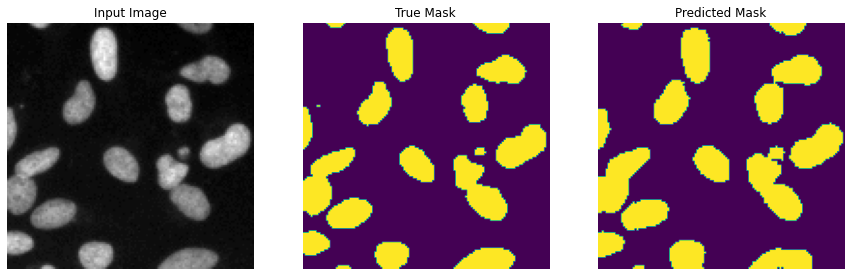

In [22]:
#5. Deploy model
show_predictions(test_batches,3)